# This project demonstrates how individual quarters can be modelled separately. 
Tests are performed on noisy simulations.

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from Kepler_ACF import corr_run
import h5py
from gatspy.periodic import LombScargle
import sys
from Kepler_ACF import corr_run
from multiprocessing import Pool
import glob
from measure_GP_rotation import bin_data
from recover_kepler_injections import recover_injections
import emcee
import corner
import george
from george.kernels import ExpSine2Kernel, ExpSquaredKernel, WhiteKernel
%matplotlib inline

# Load and plot data and set paths

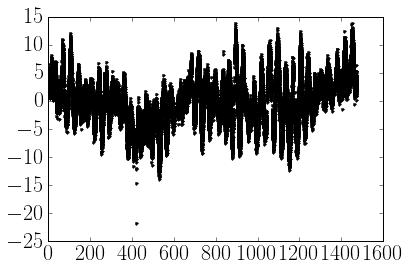

In [22]:
id = str(int(1)).zfill(4)
path = "../simulations/kepler_injections"
x, y, yerr = np.genfromtxt("{0}/{1}.txt".format(path, id)).T  # load data
plt.plot(x, y, "k.")

# Find ACF period

Calculating ACF...
Calculating errors and asymmetries...
no harmonic found or harmonic not 1st peak
6 Peaks kept
>>>>>>>>>> [-0.71006934  2.03825659  3.97945334  0.71006934 -1.33329566 -6.07390246]
2.50000599337
1.11803666907
calculating var for P_med...
saving figure ../simulations/kepler_injections/0001_full.png
PERIOD =  27.391307825 +/- 1.11803666907
saving as ../simulations/kepler_injections/0001_result.txt
acf period, err =  [ 27.39130783   1.11803667]


/Users/ruthangus/projects/GProtation/code/tests/Kepler_ACF.py:568: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 6
  delta_keep_pos = delta_keep_pos[ind_keep < ind_gap[0]]


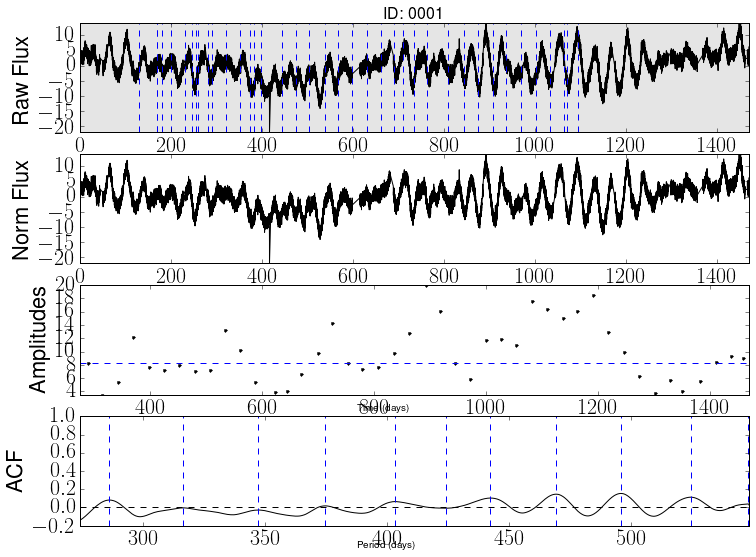

RuntimeError: LaTeX was not able to process the following string:
b'ID: C27b_lc'
Here is the full report generated by LaTeX: 

This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./1a314c1a85f15873c059b96fc6f9e5d2.tex
LaTeX2e <2015/01/01>
Babel <3.9l> and hyphenation patterns for 79 languages loaded.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2015/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2015/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/local/texlive/2015/texmf-dist/tex/latex/psnfss/courier.sty)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1enc.def))
(/usr/local/texlive/2015/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

)
No file 1a314c1a85f15873c059b96fc6f9e5d2.aux.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1cmr.fd)
(/usr/local/texlive/2015/texmf-dist/tex/latex/psnfss/ot1pnc.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
(/usr/local/texlive/2015/texmf-dist/tex/latex/psnfss/ot1phv.fd)
! Missing $ inserted.
<inserted text> 
                $
l.12 ...{16.000000}{20.000000}{\sffamily ID: C27b_
                                                  lc}
! Extra }, or forgotten $.
l.12 ....000000}{20.000000}{\sffamily ID: C27b_lc}
                                                  
! Missing $ inserted.
<inserted text> 
                $
l.13 \end{document}
                   
[1] (./1a314c1a85f15873c059b96fc6f9e5d2.aux) )
(\end occurred inside a group at level 1)

### simple group (level 1) entered at line 12 ({)
### bottom level
(see the transcript file for additional information)
Output written on 1a314c1a85f15873c059b96fc6f9e5d2.dvi (1 page, 352 bytes).
Transcript written on 1a314c1a85f15873c059b96fc6f9e5d2.log.


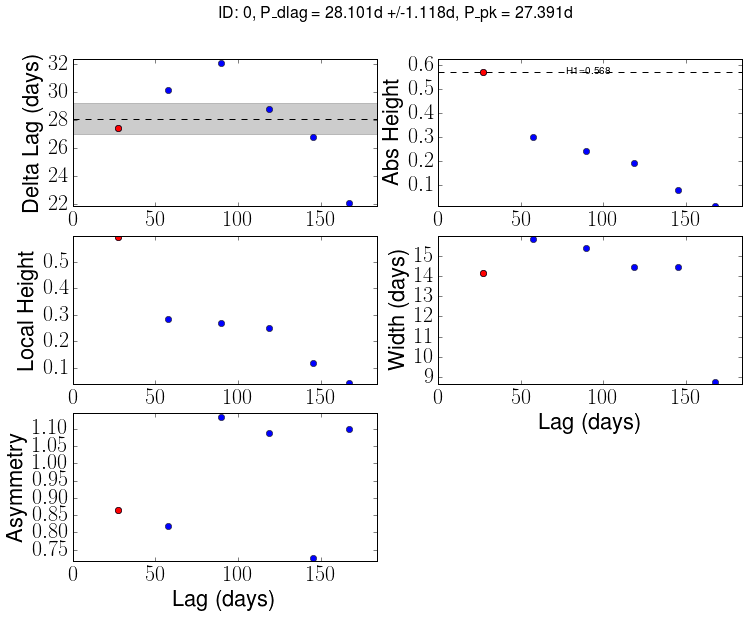

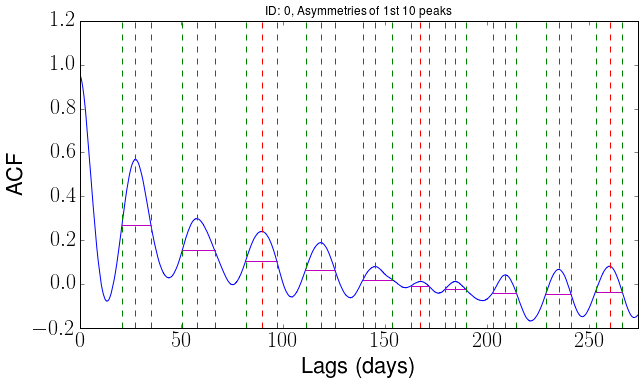

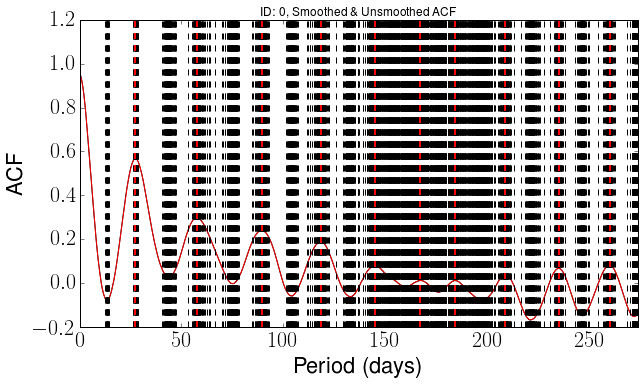

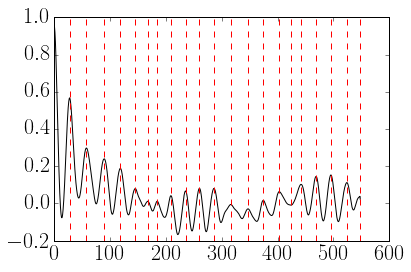

In [21]:
fn = "../simulations/kepler_injections"  # where to save results
corr_run(x, y, yerr, id, fn, saveplot=True)  # the ACF function

In [23]:
p_init = np.genfromtxt("{0}/{1}_result.txt".format(fn, id))  # the resulting period (saved in a text file)
print("acf period, err = ", p_init)

acf period, err =  [ 27.39130783   1.11803667]


# Set up the MCMC parameters and prepare the data

A function that splits the lc into quarters

In [24]:
def split_into_quarters(x, y, yerr):
    _, qs = np.genfromtxt("quarters.txt", skip_header=1).T
    qs -= qs[0]
    newx, newy, newyerr = [], [], []
    for i in range(len(qs)-1):
        m = (qs[i] < x) * (x < qs[i+1])
        if len(x[m]):  # only if that quarter exists
            newx.append(x[m])
            newy.append(y[m])
            newyerr.append(yerr[m])
    m = (x > qs[-1])
    newx.append(x[m])
    newy.append(y[m])
    newyerr.append(yerr[m])
    return newx, newy, newyerr

Data prep

In [66]:
npts = int(p_init[0] / 50. * 48)  # 10 points per period - for either binning or subsampling
xsub, ysub, yerrsub = x[::npts], y[::npts], yerr[::npts]  # subsample data
xb, yb, yerrb = split_into_quarters(xsub, ysub, yerrsub)  # split into quarters
nquarters = len(xb)
print(nquarters, npts, p_init[0])

17 26 27.391307825


Set prior limits and initial parameter values

In [105]:
plims = [p_init[0] - .99*p_init[0], p_init[0] + 3*p_init[0]]  # limits on the prior
A, l, g, s, p = np.exp(.1), np.exp(1), np.exp(.6), np.exp(-16), p_init[0]
#As = np.ones(nquarters) * A
#sigmas = np.ones(nquarters) * s
#theta_init = [As, [l], [g], sigmas, [p]]
#theta_init = [i for j in theta_init for i in j]

theta_init = [A, l, g, s, p]
theta_init = np.log(theta_init)
print(theta_init)

[  0.1          1.           0.6        -16.           3.31022573]


# Plot initial guess

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


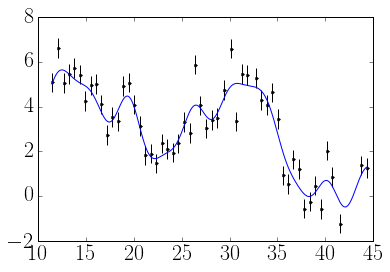

In [106]:
q = 1  # quarter 1
k = A * ExpSquaredKernel(l) * ExpSine2Kernel(g, p)
gp = george.GP(k)
gp.compute(xb[q], yerrb[q])
xs = np.linspace(xb[q][0], xb[q][-1], 1000)
mu, cov = gp.predict(yb[q], xs)

plt.errorbar(xb[q], yb[q], yerr=yerrb[q], fmt="k.", capsize=0)
plt.plot(xs, mu)

# MCMC functions

In [121]:
def lnprior_quarters(theta, plims):
    """
    plims is a tuple, list or array containing the lower and upper limits for
    the rotation period. These are logarithmic!
    theta = A, l, Gamma, s, P
    """
    nqs = (len(theta) - 3) / 2
    if np.any(theta[:nqs] < -20) or np.any(theta[:nqs] > 20) \
        or theta[nqs+1] < theta[nqs+4] or theta[nqs+2] < -20 \
        or 20 < theta[nqs+2] or np.any(theta[nqs+3:2*nqs+3] < -20) \
        or np.any(theta[nqs+3:2*nqs+3] > 20) \
        or theta[nqs+4] < plims[0] or plims[1] < theta[nqs+4]:
        return -np.inf
    return 0.

In [122]:
def lnprior(theta, plims):
    """
    plims is a tuple, list or array containing the lower and upper limits for
    the rotation period. These are logarithmic!
    theta = A, l, Gamma, s, P
    """
    if -20 < theta[0] < 20 and theta[4] < theta[1] and -20 < theta[2] < 20 \
    and -20 < theta[3] < 20 and plims[0] < theta[4] < plims[1]:
        return 0.
    return -np.inf

In [123]:
def lnprob(theta, x, y, yerr, plims):
    #nqs = len(theta - 3) / 2  # calculate the number of quarters from the number of parameters
    ll = 0
    for i in range(len(x)):
        #t = [theta[i], theta[nqs], theta[nqs+1], theta[nqs+2+i], theta[-1]]
        ll += lnlike(theta, x[i], y[i], yerr[i])
    return ll + lnprior(theta, plims)

In [124]:
def lnlike(theta, x, y, yerr):
    theta = np.exp(theta)
    k = theta[0] * ExpSquaredKernel(theta[1]) \
            * ExpSine2Kernel(theta[2], theta[4])
    gp = george.GP(k, solver=george.HODLRSolver)
    try:
        gp.compute(x, np.sqrt(theta[3]+yerr**2))
    except (ValueError, np.linalg.LinAlgError):
        return 10e25
    return gp.lnlikelihood(y, quiet=True)

# Run MCMC

In [129]:
# test the lhf works
import time
start = time.time()
print(lnprob(theta_init, x, y, yerr, plims), lnprior(theta_init, plims))
end = time.time()
print(end-start)

-inf -inf
10.768113851547241


In [115]:
ndim, nwalkers = len(theta_init), 2*len(theta_init) + 2
p0 = [theta_init+1e-4*np.random.rand(ndim) for i in range(nwalkers)]
args = (x, y, yerr, plims)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
p0, lp, state = sampler.run_mcmc(p0, 2)
sampler.reset()
p0, lp, state = sampler.run_mcmc(p0, 5)

# save samples
f = h5py.File("samples.h5", "w")
data = f.create_dataset("samples", np.shape(sampler.chain))
data[:, :] = np.array(sampler.chain)
f.close()

emcee: Exception while calling your likelihood function:
  params: [  0.10001259   1.00006068   0.60002582 -15.99996479   3.31028464]
  args: (array([  0.00000000e+00,   2.04345543e-02,   4.08690084e-02, ...,
         1.47040097e+03,   1.47042141e+03,   1.47046227e+03]), array([ 6.70621402,  3.38550473,  3.4971213 , ...,  4.28776995,
        6.41623285,  4.22473661]), array([ 0.42254463,  0.42982036,  0.43020096, ...,  0.44164139,
        0.44216087,  0.44035038]), [0.27391307825000055, 109.56523130000001])
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-110-1fca597551b2>", line 6, in lnprob
    ll += lnlike(theta, x[i], y[i], yerr[i])
  File "<ipython-input-111-a2a415deb339>", line 3, in lnlike
    k = theta[0] * ExpSquaredKernel(theta[1])             * ExpSine2Kernel(theta[2], theta[4])
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/george/kernels.py", line 310, in __init__
    super(RadialKernel, self).__init__(*(np.append(extra, metric)),
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py", line 4148, in append
    values = ravel(values)
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py", line 1477, in ravel
    return asanyarray(a).ravel(order)
  File "/Users/ruthangus/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py", line 5

KeyboardInterrupt: 